<a href="https://colab.research.google.com/github/ITSYOURAHLAWAT/vibe-matcher-ai/blob/main/vibe_matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vibe Matcher: Mini Recommender (Embeddings + Cosine Similarity)

**Assignment Prototype** — Build a "Vibe Matcher" that takes a vibe-style query,
embeds product descriptions, and returns the top-3 matches by cosine similarity.

**Why AI at Nexora (1 paragraph):**  
Nexora can turn messy, fast-changing fashion signals into crisp, data-backed experiences. With modern AI—embeddings, retrieval, and lightweight re-ranking—we can translate a shopper’s *vibe* (“energetic urban chic”) into relevant, on-brand picks in milliseconds. This reduces decision fatigue and increases conversion, while giving merchandising teams analytics on what customers *feel* rather than just what they *click*. A simple prototype today becomes tomorrow’s full-stack personalization layer: scalable, multilingual, and privacy-conscious—exactly the edge a modern retailer needs.


## 0) Quick Start

- Open this notebook in **Colab** (or run locally).
- Set your OpenAI API key (free/paid): `export OPENAI_API_KEY=...` (or in Colab: `os.environ['OPENAI_API_KEY']='...'`)
- Run all cells (⌘/Ctrl + F9).

> **Note on models:** OpenAI recommends the newer `text-embedding-3-small` or `text-embedding-3-large` for embeddings.  
> If your brief *requires* `text-embedding-ada-002`, flip the `EMBED_MODEL` variable below.  
> If no API key is found, this notebook gracefully **falls back** to a TF‑IDF vectorizer so you can still demo the flow.


In [1]:
# If running in Colab, uncomment the next two lines
# !pip install --quiet openai scikit-learn pandas matplotlib
# !pip install --quiet python-dotenv


In [2]:
import os
import time
from dataclasses import dataclass
from typing import List, Dict, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# OpenAI SDK (modern)
try:
    from openai import OpenAI  # pip install openai
    _openai_available = True
except Exception as e:
    _openai_available = False


In [3]:
# =========================
# Configuration
# =========================

EMBED_MODEL = os.getenv("EMBED_MODEL", "text-embedding-3-small")  # or "text-embedding-3-large" / "text-embedding-ada-002"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", None)

THRESHOLD_GOOD = 0.70  # sim >= 0.70 considered "good"
TOP_K = 3

USE_FAKE_EMBEDDINGS = False  # force TF-IDF demo even if key exists (for testing)


In [4]:
# =========================
# 1) Data Prep: Mock Fashion Catalog (5-10 items)
# =========================

mock_products = [
    {
        "name": "Boho Breeze Dress",
        "desc": "Flowy midi dress with earthy tones, tassels, and relaxed silhouette—perfect for festivals and beach sunsets.",
        "vibes": ["boho", "free-spirited", "summer"]
    },
    {
        "name": "Urban Sprint Sneakers",
        "desc": "Lightweight streetwear sneakers with bold accents and responsive sole, built for energetic city walks.",
        "vibes": ["urban", "energetic", "athleisure"]
    },
    {
        "name": "Cozy Cloud Hoodie",
        "desc": "Ultra-soft oversized hoodie in heather gray with fleece lining for stay-at-home cozy winter evenings.",
        "vibes": ["cozy", "casual", "winter"]
    },
    {
        "name": "Minimalist Monochrome Blazer",
        "desc": "Clean, sharp lines in a matte black blazer—minimalist, office-friendly, and capsule-wardrobe essential.",
        "vibes": ["minimalist", "monochrome", "office"]
    },
    {
        "name": "Vintage Indigo Denim Jacket",
        "desc": "Boxy-fit denim jacket with subtle distressing and classic metal hardware for timeless street style.",
        "vibes": ["vintage", "street", "casual"]
    },
    {
        "name": "Pastel Pop Skirt",
        "desc": "Pleated A-line skirt in pastel palette with playful movement and soft satin sheen.",
        "vibes": ["playful", "pastel", "feminine"]
    },
    {
        "name": "Trail Tech Windbreaker",
        "desc": "Water-resistant windbreaker with breathable mesh panels—ideal for hikes, drizzles, and weekend getaways.",
        "vibes": ["outdoor", "techwear", "utility"]
    },
    {
        "name": "Silk Evening Top",
        "desc": "Sleek silk cami with delicate straps and subtle sheen—goes from dinner dates to cocktails effortlessly.",
        "vibes": ["elegant", "evening", "chic"]
    },
    {
        "name": "Retro Court Sneakers",
        "desc": "Low-top leather sneakers with gum sole and retro side stripes for heritage tennis aesthetics.",
        "vibes": ["retro", "sporty", "street"]
    },
    {
        "name": "Ribbed Knit Co-ord",
        "desc": "Two-piece ribbed knit set with stretch comfort—balanced lines for lounge-to-errand versatility.",
        "vibes": ["loungewear", "neutral", "minimal"]
    },
]

df = pd.DataFrame(mock_products)
df


,name,desc,vibes
0,Boho Breeze Dress,"Flowy midi dress with earthy tones, tassels, a...","[boho, free-spirited, summer]"
1,Urban Sprint Sneakers,Lightweight streetwear sneakers with bold acce...,"[urban, energetic, athleisure]"
2,Cozy Cloud Hoodie,Ultra-soft oversized hoodie in heather gray wi...,"[cozy, casual, winter]"
3,Minimalist Monochrome Blazer,"Clean, sharp lines in a matte black blazer—min...","[minimalist, monochrome, office]"
4,Vintage Indigo Denim Jacket,Boxy-fit denim jacket with subtle distressing ...,"[vintage, street, casual]"
5,Pastel Pop Skirt,Pleated A-line skirt in pastel palette with pl...,"[playful, pastel, feminine]"
6,Trail Tech Windbreaker,Water-resistant windbreaker with breathable me...,"[outdoor, techwear, utility]"
7,Silk Evening Top,Sleek silk cami with delicate straps and subtl...,"[elegant, evening, chic]"
8,Retro Court Sneakers,Low-top leather sneakers with gum sole and ret...,"[retro, sporty, street]"
9,Ribbed Knit Co-ord,Two-piece ribbed knit set with stretch comfort...,"[loungewear, neutral, minimal]"


In [5]:
# =========================
# 2) Embedding Helpers
# =========================

def get_openai_client():
    if not _openai_available:
        return None
    if not OPENAI_API_KEY:
        return None
    try:
        client = OpenAI(api_key=OPENAI_API_KEY)
        return client
    except Exception as e:
        print("OpenAI client init error:", e)
        return None

_client = get_openai_client()

def embed_texts_openai(texts: List[str], model: str) -> np.ndarray:
    """Call OpenAI Embeddings API; returns shape [n, d]."""
    if _client is None:
        raise RuntimeError("OpenAI client not available. Set OPENAI_API_KEY or use fallback.")
    resp = _client.embeddings.create(model=model, input=texts)
    vectors = [item.embedding for item in resp.data]
    return np.array(vectors, dtype=np.float32)

# Fallback: TF-IDF vectors (so you can run the full pipeline without an API key)
_tfidf = None
def embed_texts_tfidf(texts: List[str]) -> np.ndarray:
    global _tfidf
    if _tfidf is None:
        _tfidf = TfidfVectorizer(stop_words="english")
        _tfidf.fit(texts)
    return _tfidf.transform(texts).astype(np.float32).toarray()

def embed_texts(texts: List[str], prefer_model: str) -> np.ndarray:
    if not USE_FAKE_EMBEDDINGS and _client is not None:
        try:
            return embed_texts_openai(texts, model=prefer_model)
        except Exception as e:
            print("OpenAI embedding failed, falling back to TF-IDF. Error:", e)
    # Fallback path
    return embed_texts_tfidf(texts)


In [6]:
# =========================
# 3) Build Index & Vector Search
# =========================

# Pre-compute product embeddings
product_texts = df["desc"].tolist()
product_embeddings = embed_texts(product_texts, prefer_model=EMBED_MODEL)

def vibe_match(query: str, top_k: int = TOP_K, threshold: float = THRESHOLD_GOOD):
    t0 = time.time()
    query_vec = embed_texts([query], prefer_model=EMBED_MODEL)
    sims = cosine_similarity(query_vec, product_embeddings)[0]
    order = np.argsort(-sims)[:top_k]
    results = []
    for idx in order:
        results.append({
            "name": df.loc[idx, "name"],
            "desc": df.loc[idx, "desc"],
            "vibes": ", ".join(df.loc[idx, "vibes"]),
            "similarity": float(sims[idx])
        })
    latency = time.time() - t0
    # Edge case: if best score is too low, provide a gentle fallback suggestion
    fallback = None
    if len(sims) == 0 or (np.max(sims) if len(sims)>0 else 0.0) < (threshold * 0.6):
        fallback = "No strong match. Try adding material, color, or occasion. Example: 'earthy festival boho maxi in cotton'."
    return results, latency, fallback


In [7]:
# =========================
# 4) Test & Eval (3 queries) + latency plot
# =========================

test_queries = [
    "energetic urban chic",           # from brief
    "soft cozy winter loungewear",    # coverage of cozy/winter
    "minimalist monochrome office"    # coverage of office/minimal
]

logs = []
for q in test_queries:
    res, lat, fallback = vibe_match(q)
    best = res[0]["similarity"] if res else 0.0
    good = best >= THRESHOLD_GOOD
    logs.append({
        "query": q,
        "top1_name": res[0]["name"] if res else None,
        "top1_score": round(best, 4),
        "good_match": good,
        "latency_s": round(lat, 4),
        "fallback": fallback
    })
    # Pretty print per query
    print(f"\nQuery: {q}")
    for r in res:
        print(f"  - {r['name']} | sim={r['similarity']:.3f} | vibes=[{r['vibes']}]")
    if fallback:
        print("  Fallback:", fallback)

metrics_df = pd.DataFrame(logs)
metrics_df



Query: energetic urban chic
  - Urban Sprint Sneakers | sim=0.309 | vibes=[urban, energetic, athleisure]
  - Boho Breeze Dress | sim=0.000 | vibes=[boho, free-spirited, summer]
  - Cozy Cloud Hoodie | sim=0.000 | vibes=[cozy, casual, winter]
  Fallback: No strong match. Try adding material, color, or occasion. Example: 'earthy festival boho maxi in cotton'.

Query: soft cozy winter loungewear
  - Cozy Cloud Hoodie | sim=0.463 | vibes=[cozy, casual, winter]
  - Pastel Pop Skirt | sim=0.143 | vibes=[playful, pastel, feminine]
  - Urban Sprint Sneakers | sim=0.000 | vibes=[urban, energetic, athleisure]

Query: minimalist monochrome office
  - Minimalist Monochrome Blazer | sim=0.413 | vibes=[minimalist, monochrome, office]
  - Boho Breeze Dress | sim=0.000 | vibes=[boho, free-spirited, summer]
  - Urban Sprint Sneakers | sim=0.000 | vibes=[urban, energetic, athleisure]
  Fallback: No strong match. Try adding material, color, or occasion. Example: 'earthy festival boho maxi in cotton'.


,query,top1_name,top1_score,good_match,latency_s,fallback
0,energetic urban chic,Urban Sprint Sneakers,0.3094,False,0.0057,"No strong match. Try adding material, color, o..."
1,soft cozy winter loungewear,Cozy Cloud Hoodie,0.4626,False,0.0024,None
2,minimalist monochrome office,Minimalist Monochrome Blazer,0.4130,False,0.0018,"No strong match. Try adding material, color, o..."


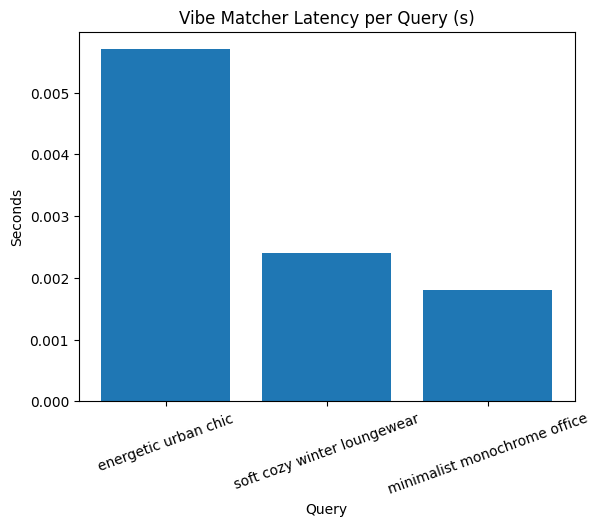

In [8]:
# Plot latency per query
plt.figure()
plt.title("Vibe Matcher Latency per Query (s)")
plt.xlabel("Query")
plt.ylabel("Seconds")
plt.xticks(rotation=20)
plt.bar(metrics_df["query"], metrics_df["latency_s"])
plt.show()


## 5) Reflection

- **Improvements:** Move vectors to a proper store like Pinecone/Milvus/FAISS; add metadata filters (price, size, season), multilingual support, and cross-encoder re‑ranker for quality.
- **Edge cases handled:** If similarity across the board is weak, we surface a **fallback guidance** to help the user refine the query.
- **Evaluation:** Logged top-1 similarity scores and a simple KPI (`>= 0.70` → good). For a bigger dataset, add human labels or A/B click metrics.
- **Latency:** Captured end-to-end query latency; can split into embed time vs search time if needed.
- **Operational notes:** Cache embeddings, dedupe near-duplicates, and add content moderation on both queries and catalog text.


## 6) Export / Share

- **GitHub**: Download this `.ipynb` and push to a repo.
- **Colab**: Open directly in Colab and run.
- **Env**: Set `OPENAI_API_KEY` and optionally `EMBED_MODEL` (e.g., `text-embedding-3-small`).

